In [1]:
import pandas as pd                          # - pandas data manipulation
from pandas import DataFrame as df           # - pandas data frame
import numpy as np                           # - numerical functions
import numpy.linalg as alg                   # - matrix functions
import matplotlib.pyplot as plt              # - plots
import seaborn as sns                        # - plots formatting
from statsmodels.tsa.stattools import acf    # - autocorrelation function
%matplotlib inline

In [2]:
# - read data, source http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

df_returns = pd.read_csv("12_Industry_Portfolios.csv", skiprows=11, nrows=1057)
df_returns.head()

,Unnamed: 0,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
0,192607,1.45,15.55,3.67,-1.18,8.01,3.16,0.83,7.04,0.11,1.77,0.37,2.24
1,192608,3.97,3.68,2.42,3.47,5.14,1.97,2.17,-1.69,-0.71,4.25,4.46,4.37
2,192609,1.14,4.80,-0.07,-3.39,5.30,-0.34,2.41,2.04,0.21,0.69,-1.23,0.35
3,192610,-1.24,-8.23,-3.16,-0.78,-4.55,-5.38,-0.11,-2.63,-2.29,-0.57,-5.16,-2.76
4,192611,5.21,-0.19,3.82,0.01,5.11,4.79,1.63,3.71,6.43,5.42,2.24,2.10


In [3]:
# - index date field to work as a time series

df_returns.rename(columns = {"Unnamed: 0":"Date"}, inplace = True)
df_returns.set_index("Date", inplace = True)

In [4]:
# - calculate the holdings vector at each point in time, weighted based on previous 12 months' data

T = df_returns.shape[0]
H = np.array([[0] * 12] * 12)
A = np.matrix([1] * 12)
A_t = np.transpose(A)

for t in range(13, T+1):
    
    R = df_returns.iloc[(t-13):(t-1)]
    
    # - get mean of each industry
    alpha = np.matrix(R.mean())
    alpha_t = np.transpose(alpha)
    
    # - annualise covariance matrix and invert
    V = 12 * np.matrix(df.cov(R))
    V_inv = alg.pinv(V)
    
    # - compute holdings vector, scale with risk constraints
    h = (V_inv - V_inv * A_t * alg.pinv(A * V_inv * A_t) * A * V_inv) * alpha_t
    h_t = np.transpose(h)
    h = 0.05 * h * np.sqrt(alg.pinv(h_t * V * h))
    h = np.transpose(h)
    
    H = np.append(H, h, axis=0)

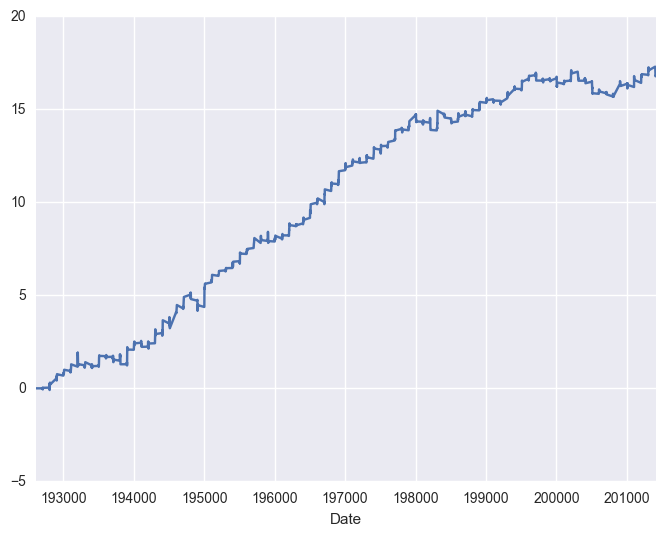

In [5]:
# - calculate returns and plot

backtest_returns = H*df_returns
backtest_returns_cumulative = backtest_returns.sum(1).cumsum()
backtest_returns_cumulative.plot(figsize=(8, 6))

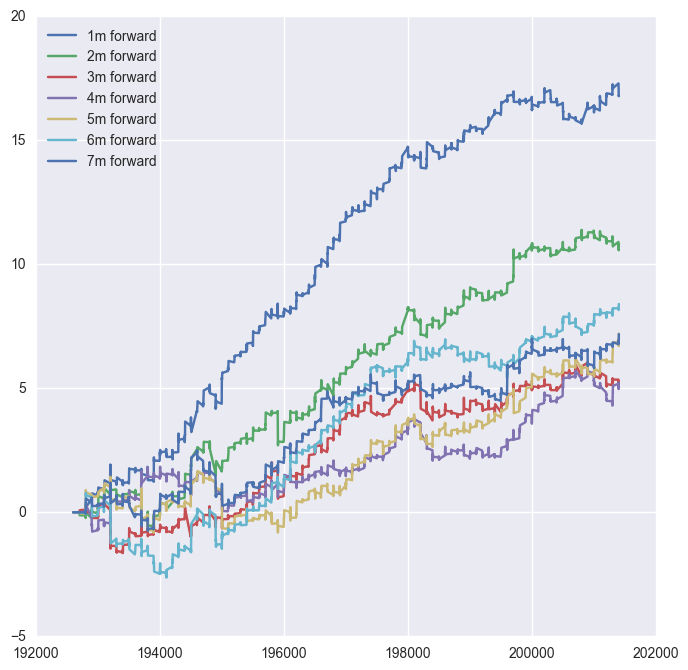

In [6]:
# - how long does this signal last? its performance appears to drop significantly after 1 month
    
months_forward = range(1, 8)
plt.figure(figsize=(8, 8))

for m in months_forward:

    T = df_returns.shape[0]
    H = np.array([[0] * 12] * (11 + m))

    for t in range(12+m, T+1):

        R = df_returns.iloc[(t-12-m):(t-0-m)]
        
        # - exact same calculations as before
        alpha = np.matrix(R.mean())
        alpha_t = np.transpose(alpha)
        V = 12 * np.matrix(df.cov(R))
        V_inv = alg.pinv(V)
        h = (V_inv - V_inv * A_t * alg.pinv(A * V_inv * A_t) * A * V_inv) * alpha_t
        h_t = np.transpose(h)
        h = 0.05 * h * np.sqrt(alg.pinv(h_t * V * h))
        h = np.transpose(h)
        H = np.append(H, h, axis=0)

    # - calculate returns and plot
    backtest_returns_new = H*df_returns
    backtest_returns_new_cumulative = backtest_returns_new.sum(1).cumsum()
    plt.plot(backtest_returns_new_cumulative, label=str(m) + "m forward")
    plt.legend(loc="upper left")


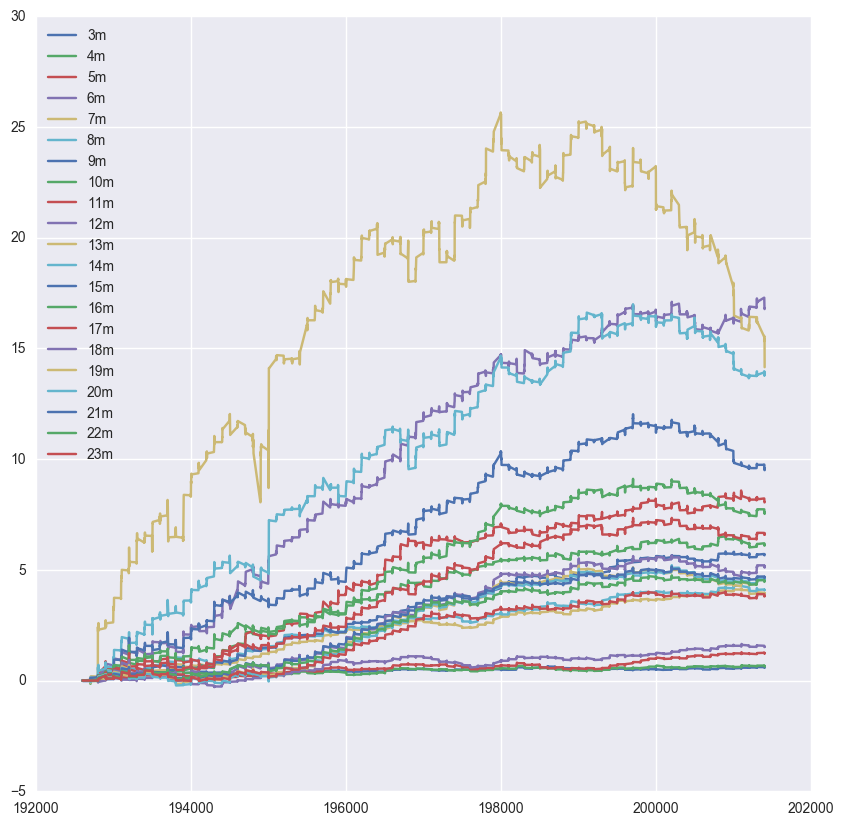

In [7]:
# - and how far back should the data be collected to optimise this strategy? looks like 13 months is the
#   winner (by quite a margin - why is this the case?)
    
months_lookback = range(3, 24)
plt.figure(figsize=(10, 10))

# - initialise all returns data frame so we can save returns for each scenario
all_returns = df(index = df_returns.index)

for m in months_lookback:

    T = df_returns.shape[0]
    H = np.array([[0] * 12] * (m))

    for t in range(m+1, T+1):

        R = df_returns.iloc[(t-(m+1)):(t-1)]
        
        # - exact same calculations as before
        alpha = np.matrix(R.mean())
        alpha_t = np.transpose(alpha)
        V = 12 * np.matrix(df.cov(R))
        V_inv = alg.pinv(V)
        h = (V_inv - V_inv * A_t * alg.pinv(A * V_inv * A_t) * A * V_inv) * alpha_t
        h_t = np.transpose(h)
        h = 0.05 * h * np.sqrt(alg.pinv(h_t * V * h))
        h = np.transpose(h)
        H = np.append(H, h, axis=0)

    # - calculate returns and plot
    backtest_returns_new = H*df_returns
    backtest_returns_new_cumulative = backtest_returns_new.sum(1).cumsum()
    all_returns[str(m) + "m"] = backtest_returns_new_cumulative
    plt.plot(backtest_returns_new_cumulative, label=str(m) + "m")
    plt.legend(loc="upper left")

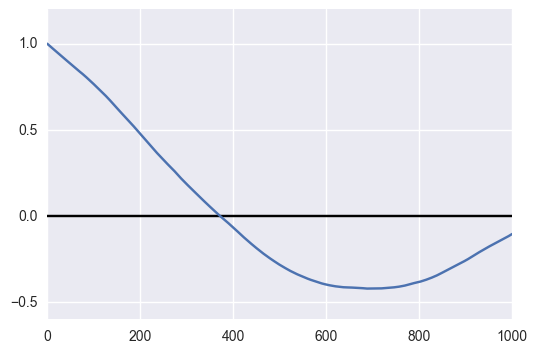

In [8]:
# - TO DO: expand on autocorrelation

plt.plot(acf(backtest_returns_cumulative, nlags=1000))
plt.hlines(0, 0, 1000)

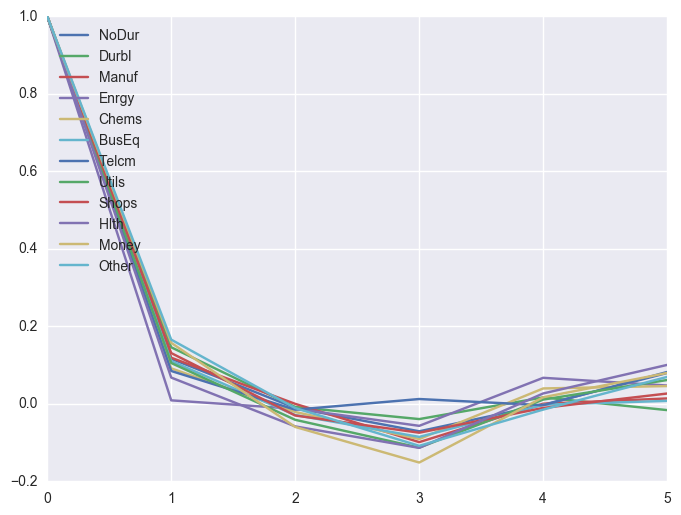

In [9]:
# - are the individual industry returns correlated with themselves? doesn't seem so

plt.figure(figsize=(8,6))
for industry in df_returns.columns:
    plt.plot(acf(df_returns[industry], nlags=5), label=industry)

plt.legend(loc="upper left")

In [10]:
# - now let's try some walk-forward optimisation
# - we have a total of 1057 months of data points, that's 88 years + 1 month, so let's split out data
#   into 22 intervals of 4 years each, i.e. 48 months each, and then for each interval, use the lookback
#   period trained on the previous interval's returns

# - two ways of doing this:
# - 1. use the saved returns from previous run to determine optimum lookback period at
#   each interval (computationally efficient since we've done this already)
# - 2. write loop to calculate this while moving forward in time (applicable to new data)

# - let's do both to ensure self-consistency

In [11]:
# - TO DO: write process to identify optimum lookback based on this data frame
# - 1. use the saved returns from previous run to determine optimum lookback period
#   at each interval (computationally efficient since we've done this already)

all_returns.iloc[0:15]

,3m,4m,5m,6m,7m,8m,9m,10m,11m,12m,...,14m,15m,16m,17m,18m,19m,20m,21m,22m,23m
Date,,,,,,,,,,,,,,,,,,,,,
192607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192610,-0.007537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192611,-0.005190,0.019279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192612,-0.023162,0.005502,0.008358,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192701,-0.022623,0.002177,0.024101,0.000683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192702,-0.014345,-0.003481,0.038643,0.015140,0.030635,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192703,-0.017374,0.013412,0.060439,0.047488,0.063351,0.080125,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# - 2. write loop to calculate this while moving forward in time (applicable to new data)

intervals_months = 48

# - assume 12m lookback for the first interval as we have no prior data
optimum_lookback_array = np.array([12])
optimum_lookback_array_v2 = np.array([12])

# - each interval where we train for optimal lookback for next interval
for t_interval in range(0, 21):
    
    df_returns_interval = df_returns.iloc[((t_interval) * intervals_months):((t_interval + 1) * intervals_months)]

    months_lookback = range(3, 24)
    months_lookback_results = []

    for m in months_lookback:
            
        H = np.array([[0] * 12] * (m))

        for t in range(m+1, intervals_months+1):

            R = df_returns_interval.iloc[(t-(m+1)):(t-1)]

            # - exact same calculations as before
            alpha = np.matrix(R.mean())
            alpha_t = np.transpose(alpha)
            V = 12 * np.matrix(df.cov(R))
            V_inv = alg.pinv(V)
            h = (V_inv - V_inv * A_t * alg.pinv(A * V_inv * A_t) * A * V_inv) * alpha_t
            h_t = np.transpose(h)
            h = 0.05 * h * np.sqrt(alg.pinv(h_t * V * h))
            h = np.transpose(h)
            H = np.append(H, h, axis=0)

        # - calculate returns and plot
        backtest_returns_new = H*df_returns_interval
        backtest_returns_new_cumulative = backtest_returns_new.sum(1).sum()
        months_lookback_results.append([m, backtest_returns_new_cumulative])
        
    # - pick highest months_lookback
    months_lookback_results = df(months_lookback_results, columns=["months", "returns"])
    optimum_lookback = months_lookback_results["months"][months_lookback_results["returns"].idxmax()]
    optimum_lookback_array = np.append(optimum_lookback_array, optimum_lookback)
    
    # - what if we excluded 13m from our parameter options?
    months_lookback_results = months_lookback_results.iloc[[row for row in months_lookback_results.index != 11]]
    optimum_lookback_v2 = months_lookback_results["months"][months_lookback_results["returns"].idxmax()]
    optimum_lookback_array_v2 = np.append(optimum_lookback_array_v2, optimum_lookback_v2)

In [13]:
optimum_lookback_array

array([12, 13, 13, 13, 13, 12, 12, 12, 12, 13, 12, 12, 10, 13,  9, 12, 14,
       12, 14, 12,  6,  9], dtype=int64)

In [14]:
optimum_lookback_array_v2

array([12, 13, 13, 13, 13, 12, 12, 12, 12, 13, 12, 12, 10, 13,  9, 12, 13,
       12, 15, 12,  6,  9], dtype=int64)

In [15]:
# - now calculate returns

intervals_months = 48
H = np.array([[0] * 12] * optimum_lookback_array[0])

# - for each interval, use optimum lookback period trained from the previous interval
for t_interval in range(0, 22):
    
    m = optimum_lookback_array[t_interval]

    # - for the first interval, start at end of lookback period, otherwise start at beginning
    if t_interval == 0:
        t_start = m+1
    else:
        t_start = 1
        
    for t in range(t_start, intervals_months+1):

        R = df_returns.iloc[(t-(m+1) + (t_interval)*intervals_months):(t-1 + (t_interval)*intervals_months)]
        
        # - exact same calculations as before
        alpha = np.matrix(R.mean())
        alpha_t = np.transpose(alpha)
        V = 12 * np.matrix(df.cov(R))
        V_inv = alg.pinv(V)
        h = (V_inv - V_inv * A_t * alg.pinv(A * V_inv * A_t) * A * V_inv) * alpha_t
        h_t = np.transpose(h)
        h = 0.05 * h * np.sqrt(alg.pinv(h_t * V * h))
        h = np.transpose(h)
        H = np.append(H, h, axis=0)

# - calculate returns and plot
backtest_returns_new = H*df_returns.iloc[0:(22*48)]
backtest_returns_new_cumulative = backtest_returns_new.sum(1).cumsum()
        

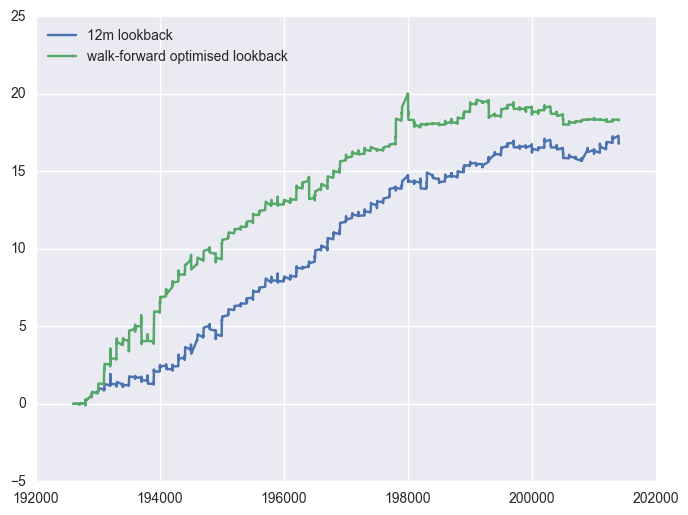

In [16]:
# - updating the lookback period with a walk-forward window gives better performance

plt.figure(figsize=(8, 6))
plt.plot(backtest_returns_cumulative, label="12m lookback")
plt.plot(backtest_returns_new_cumulative, label="walk-forward optimised lookback")
plt.legend(loc="upper left")